In [0]:
import os
import sys
import cv2
import numpy  as np
import pandas as pd
from glob import glob
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K  
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from sklearn.model_selection import LeaveOneOut
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv3D, Flatten, Lambda, Activation, Dropout, MaxPooling3D

## **Ingresando a Drive**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## ***Tratando el flujo***

In [0]:
def scale_ycrcb(img_ycrcb):
    """
    Retorna una imagen escalada en (-128,128)
    """
    tem = np.zeros(img_ycrcb.shape, dtype=int)
    tem[:,:,0] = img_ycrcb[:,:,0]
    tem[:,:,1] = img_ycrcb[:,:,1] + (-128)
    tem[:,:,2] = img_ycrcb[:,:,2] + (-128)
    return tem

In [0]:
def arrowsimg(array_dydx, defacing = 0):
    """
    image_dydx: dydx Channels of an image (2D)
    defacing: If the reference map is defacing with respect to the YCrCb map
    return: magnitudes and angles of the arrows
    """
    #___________________________________________________________________________
    assert(array_dydx.ndim == 3), "The array is not 3D array"
    assert(array_dydx.shape[2] == 2), "Dimension is not valid (Channels)"
    #___________________________________________________________________________
    array_dydx = np.array(array_dydx)
    magnitudes, angles = cv2.cartToPolar(array_dydx[:,:,1].astype(float),
                                         array_dydx[:,:,0].astype(float),
                                         angleInDegrees=True)
    if defacing != 0:
        for row in range(angles.shape[0]):
            for col in range(angles.shape[1]):
                angle = angles[row,col]
                if (0.0 <= angle < 90.0 ): # first quadrant
                    angles[row,col] = angle + (360 - defacing)
                elif (90.0 <= angle < 180.0 ): # second quadrant
                    if defacing == 90:
                        angles[row,col] = angle - defacing
                    else:
                        angles[row,col] = angle + (360 - defacing)
                elif (180.0 <= angle < 270.0 ): # third quadrant
                    if defacing == 270:
                        angles[row,col] = angle + (360 - defacing)
                    else:
                        angles[row,col] = angle - defacing
                elif (270.0 <= angle <= 360.0 ): # fourth quadrant
                    angles[row,col] = angle - defacing

    return magnitudes, angles

## ***Cinemáticas***

***Velocidad normal***

In [0]:
def vel_normal(vty1,vtx1,mag1,vty2,vtx2):
    
    w=vtx1.shape[0]   #y
    h=vtx1.shape[1]   #x
    vty_dev=np.zeros((w,h))
    vtx_dev=np.zeros((w,h))  
    for i in range(w):
        for j in range(h):
            if(round(i+mag1[i,j])>=w or round(j+mag1[i,j])>=h):
                vty_dev[i,j]=0
                vtx_dev[i,j]=0
            else:
                vty_dev[i,j]=vty2[int(round(i+mag1[i,j])),int(round(j+mag1[i,j]))]-vty1[i,j]
                vtx_dev[i,j]=vtx2[int(round(i+mag1[i,j])),int(round(j+mag1[i,j]))]-vtx1[i,j]
    
    mag_dev,d_dev=cv2.cartToPolar(vtx_dev,vty_dev)    #cartTopolar(x,y)
    vny,vnx=vel_tang(mag_dev,vty_dev,vtx_dev)
    return vny,vnx,mag_dev

***Velocidad tangencial***

In [0]:
def vel_tang(mag,y,x):
    vty,vtx=np.zeros((mag.shape[0],mag.shape[1])),np.zeros((mag.shape[0],mag.shape[1]))
    for i in range(mag.shape[0]):
        for j in range(mag.shape[1]):
            if(mag[i,j]==0):
                vty[i,j]=0
                vtx[i,j]=0
            else:
                vty[i,j]=y[i,j]/mag[i,j]
                vtx[i,j]=x[i,j]/mag[i,j]
    return vty,vtx

***Aceleración normal***

In [0]:
def acl_normal(f_mag,mag_vn):
    w=f_mag.shape[0]   #y
    h=f_mag.shape[1]   #x
    an=np.zeros((w,h)) 
    for i in range(w):
        for j in range(h):
            an[i,j]=f_mag[i,j]*mag_vn[i,j]
    
    return an

***Aceleración tangencial***

In [0]:
def acl_tan(mag1,mag2):
    
    w=mag1.shape[0]   #y
    h=mag1.shape[1]   #x
    mag_dev=np.zeros((w,h))  
    for i in range(w):
        for j in range(h):
            if(round(i+mag1[i,j])>=w or round(j+mag1[i,j])>=h):
                mag_dev[i,j]=0                
            else:
                mag_dev[i,j]=mag2[int(round(i+mag1[i,j])),int(round(j+mag1[i,j]))]-mag1[i,j]
    
    return mag_dev

***Calculando las características***

In [0]:
import zipfile
zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/Tesis/recortados_ventrículos.zip", 'r')
zip_ref.extractall("/content/gdrive/My Drive/Tesis/")
zip_ref.close()

In [0]:
def cinematic_features(pathology, slice_):
  folder = '/content/gdrive/My Drive/Tesis/OF-PPM/' + pathology + '/' + slice_ + '/'
  frames = sorted(glob(os.path.join(folder, '*.ppm')))
  cc_folder = '/'.join(folder.split('/')[:-4]) + '/AT-PPM/' + '/'.join(folder.split('/')[-3:-2])
  os.mkdir(cc_folder)
  cc_folder = '/'.join(folder.split('/')[:-4]) + '/AT-PPM/' + '/'.join(folder.split('/')[-3:-1])
  os.mkdir(cc_folder)
  print('Empezando a calcular la cinemática...')
  for i, image in enumerate(frames):
    image_name = image.split('/')[-1]
    print("Imaging prosesing... ")
  
    if(image != folder+'000029.ppm'):
      a = plt.imread(image)
      if (len(frames) == i+1):
          b = plt.imread(frames[0])
      else:
          b = plt.imread(frames[i+1])
      img_a = cv2.cvtColor(a, cv2.COLOR_BGR2YCrCb)
      img_b = cv2.cvtColor(b, cv2.COLOR_BGR2YCrCb)

      imgsc_a = scale_ycrcb(img_a)[:,:,1:]
      imgsc_b = scale_ycrcb(img_b)[:,:,1:]
      mag_a, ang_a = arrowsimg(imgsc_a, 90)
      mag_b, ang_b = arrowsimg(imgsc_b, 90)
      
      #Charging cinematics
      vty_a, vtx_a = vel_tang(mag_a,imgsc_a[:,:,0], imgsc_a[:,:,1]) #VT_A        
      vty_b, vtx_b = vel_tang(mag_b,imgsc_b[:,:,0], imgsc_b[:,:,1]) #VT_B
      mag_vt = np.sqrt((vtx_a)**2 + (vty_a)**2)
      vny, vnx, mag_vn = vel_normal(vty_a, vtx_a,mag_a,vty_b,vtx_b) #VN
      mag_dev = acl_tan(mag_a,mag_b) #AT
      an_ = acl_normal(mag_a,mag_vn) #AN
      an_img = np.array(mag_dev, dtype = np.uint8)
      cinematic = cv2.applyColorMap(an_img, cv2.COLORMAP_JET)
      cv2.imwrite( cc_folder + '/' + image_name[:-4] + '.jpg', cinematic)
      print('Saving...' + cc_folder + '/' + image_name[:-4] + '.jpg')
   
 
  #return an_
#cinematic_features('SC-HF-I-01', '7')

In [0]:
first_pat = open('/content/gdrive/My Drive/Tesis/recortados_ventrículos_LV_RV/pri_pat.txt', 'r')
secon_pat = open('/content/gdrive/My Drive/Tesis/recortados_ventrículos_LV_RV/seg_pat.txt', 'r')
third_pat = open('/content/gdrive/My Drive/Tesis/recortados_ventrículos_LV_RV/ter_pat.txt', 'r')
four_pat  = open('/content/gdrive/My Drive/Tesis/recortados_ventrículos_LV_RV/cua_pat.txt', 'r')

In [0]:
print("First pathology")
for i in first_pat:
  pathology, slice_ = i.split(' ')[:2] 
  pathology = '0'+pathology[2:]
  cinematic_features(pathology, slice_)
#"""
print("Second pathology")
for i in secon_pat:
  pathology, slice_ = i.split(' ')[:2]
  pathology = '1'+pathology[2:]
  cinematic_features(pathology, slice_)
    
    
print("Third pathology")
for i in third_pat:
  pathology, slice_ = i.split(' ')[:2]
  pathology = '2'+pathology[2:]
  cinematic_features(pathology, slice_)
    
    
print("Four pathology")
for i in four_pat:
  pathology, slice_ = i.split(' ')[:2]
  pathology = '3'+pathology[2:]
  cinematic_features(pathology, slice_)
#"""

First pathology
Empezando a calcular la cinemática...
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000010.jpg
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000011.jpg
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000012.jpg
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000013.jpg
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000014.jpg
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000015.jpg
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000016.jpg
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000017.jpg
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000018.jpg
Imaging prosesing... 
Saving.../content/gdrive/My Drive/Tesis/AT-PPM/0-HF-I-01/7/000019.jpg
Imaging prosesing... 
Savi

## *Creando el train y test*

In [0]:
def creating_train(path, cinematica):
  X_train, paths = [], []
  for folder_path in path:
    path_P1 = folder_path.strip().split(" ")[:2]
    path_P1 = '/content/gdrive/My Drive/Tesis/'+cinematica+'/'+path_P1[0]+"/"+path_P1[1]+"/"
    paths.append(path_P1)
    folders_P1 = sorted(glob(os.path.join(path_P1, '*.ppm')))
    imagenes = []
    for images in folders_P1:
        img = plt.imread(images)
        imagenes.append(img)
    X_train.append(imagenes)
  return np.array(X_train), np.array(paths)

In [0]:
first = ['0-HF-I-01 7','0-HF-I-02 3','0-HF-I-05 7','0-HF-I-06 4','0-HF-I-07 4','0-HF-I-08 3','0-HF-I-09 9','0-HF-I-10 9','0-HF-I-11 3','0-HF-I-12 2','0-HF-I-40 4',
         '1-HF-NI-03 3','1-HF-NI-04 2','1-HF-NI-07 3','1-HF-NI-11 8','1-HF-NI-12 4','1-HF-NI-13 8','1-HF-NI-14 8','1-HF-NI-15 6','1-HF-NI-31 6','1-HF-NI-33 3','1-HF-NI-34 8','1-HF-NI-36 6',
         '2-HYP-01 4','2-HYP-03 3','2-HYP-06 6','2-HYP-07 7','2-HYP-08 5','2-HYP-09 8','2-HYP-10 2','2-HYP-11 8','2-HYP-12 3','2-HYP-37 7','2-HYP-38 3','2-HYP-40 5',
         '3-N-02 6','3-N-03 9','3-N-05 3','3-N-06 6','3-N-07 9','3-N-09 7','3-N-10 8','3-N-11 2','3-N-40 8']

## *Red Neuronal (Conv3D)*

In [0]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=4, dim=(20,256,256,3),
                 n_classes=4, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            for j,img in enumerate(sorted(os.listdir(ID))): 
                # Store img
                #print(ID+img)
                X[i,j,:] = plt.imread(ID+img)
            #print(X[i,j])
            # Store class
            y[i] = int(ID.split('/')[-3].split('-')[0])
            #print(y[i])
        
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes) 

In [0]:
def CNN3D(inputShape, dropout, nClass, wDecay):
    inputs = Input(inputShape)
    layer = Conv3D(filters=32, kernel_size=(3,3,3), strides=(2,2,2), kernel_regularizer=regularizers.l2(wDecay),data_format='channels_last')(inputs)
    layer = Activation('relu')(layer)
    layer = MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), data_format='channels_last')(layer)
    layer = Conv3D(filters=64, kernel_size=(3,3,3), strides=(1,1,1), kernel_regularizer=regularizers.l2(wDecay),data_format='channels_last')(layer)
    layer = Activation('relu')(layer)
    layer = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), data_format='channels_last')(layer)
    layer = Conv3D(filters=128, kernel_size=(3,3,3), strides=(2,2,2), kernel_regularizer=regularizers.l2(wDecay),data_format='channels_last')(layer)
    layer = Activation('relu')(layer)
    layer = MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), data_format='channels_last')(layer)
    layer = Flatten()(layer)
    dense = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(wDecay))(layer)
    dense = Dropout(dropout)(dense)
    dense = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(wDecay))(dense)
    dense = Dropout(dropout)(dense)
    output = Dense(nClass, activation='softmax')(dense)
    model = Model(inputs = [inputs], outputs = [output], name='Convolutional3D')
        
    return model

In [0]:
K.set_floatx('float32')
K.set_image_data_format('channels_last')  
model = CNN3D((20, 256, 256, 3), 0.4, 4, 0.001)
sgd = optimizers.SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True, clipnorm=1., clipvalue=0.5)
model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])
model.summary()

W0731 15:32:50.183487 140267211483008 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "Convolutional3D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 256, 256, 3)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 9, 127, 127, 32)   2624      
_________________________________________________________________
activation (Activation)      (None, 9, 127, 127, 32)   0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 9, 63, 63, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 61, 61, 64)     55360     
_________________________________________________________________
activation_1 (Activation)    (None, 7, 61, 61, 64)     0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 30, 30, 64) 

In [0]:
def classify(X):
    model_c, pred = [], []
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    i = 1;
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        print("Iteración: ", i)
        training_generator = DataGenerator(X_train)
        validation_generator = DataGenerator(X_test, batch_size=1) 
        model = CNN3D((20, 256, 256, 3), 0.4, 4, 0.001)
        
        sgd = optimizers.SGD(lr=0.01, decay=0.1, momentum=0.9, nesterov=True, clipnorm=1., clipvalue=0.5)
        model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])
        model_cinematic = model.fit_generator(generator=training_generator,
                                              use_multiprocessing=True,
                                              workers=4,
                                              epochs=20)
        p = model.predict(validation_generator)
        #print(p)
        pred.append(p)
        model_c.append(model_cinematic)
        model.save('/content/gdrive/My Drive/Tesis/models/patient_'+ str(i) +'.h5')
        i = i+1
    return model_c, pred

***Conv3D + PPM***

In [0]:
X_train_ppm, paths_ppm = creating_train(first, 'PPM')
print(X_train_ppm.shape)
print(paths_ppm.shape)

(44, 20, 256, 256, 3)
(44,)


In [0]:
#classify(X_train_ppm, pa ths_ppm)
history_PPM = classify(paths_ppm)

(43,) (1,) Iteración:  1
Epoch 1/20


W0730 00:58:47.586977 139661892900736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/clip_ops.py:157: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


10/10 [==============================] - 8s 848ms/step - loss: 10.2293 - acc: 0.2250 - val_loss: 4.3623 - val_acc: 0.0000e+00
Epoch 2/20
10/10 [==============================] - 4s 407ms/step - loss: 6.0816 - acc: 0.3500 - val_loss: 4.3818 - val_acc: 0.0000e+00
Epoch 3/20
10/10 [==============================] - 6s 580ms/step - loss: 4.7500 - acc: 0.3750 - val_loss: 5.0798 - val_acc: 0.0000e+00
Epoch 4/20
10/10 [==============================] - 5s 488ms/step - loss: 4.0156 - acc: 0.5750 - val_loss: 5.1998 - val_acc: 0.0000e+00
Epoch 5/20
10/10 [==============================] - 6s 593ms/step - loss: 4.0711 - acc: 0.5500 - val_loss: 4.8875 - val_acc: 0.0000e+00
Epoch 6/20
10/10 [==============================] - 5s 469ms/step - loss: 4.0794 - acc: 0.4750 - val_loss: 4.6652 - val_acc: 0.0000e+00
Epoch 7/20
10/10 [==============================] - 5s 545ms/step - loss: 3.8818 - acc: 0.5750 - val_loss: 5.2594 - val_acc: 0.0000e+00
Epoch 8/20
10/10 [==============================] - 5s 523

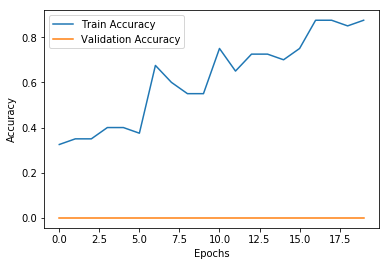

In [0]:
plt.plot(history_PPM.history['acc'], label='Train Accuracy')
plt.plot(history_PPM.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [0]:
###___________________para matriz de confusion_____________________
history_PPM, predictions_PPM = classify(paths_ppm)

Iteración:  1
Epoch 1/20
10/10 [==============================] - 7s 699ms/step - loss: 7.7435 - acc: 0.2000
Epoch 2/20
10/10 [==============================] - 5s 514ms/step - loss: 4.5052 - acc: 0.4000
Epoch 3/20Epoch 2/20

10/10 [==============================] - 6s 580ms/step - loss: 4.2218 - acc: 0.3250
Epoch 3/20Epoch 4/20
10/10 [==============================] - 5s 525ms/step - loss: 4.1406 - acc: 0.4000
Epoch 5/20
10/10 [==============================] - 5s 545ms/step - loss: 4.0014 - acc: 0.6000
Epoch 6/20
10/10 [==============================] - 5s 535ms/step - loss: 3.8343 - acc: 0.6750
Epoch 7/20
10/10 [==============================] - 6s 569ms/step - loss: 3.6741 - acc: 0.7750
Epoch 8/20
10/10 [==============================] - 5s 515ms/step - loss: 3.7323 - acc: 0.7000
Epoch 9/20
10/10 [==============================] - 6s 580ms/step - loss: 3.6242 - acc: 0.7000
Epoch 10/20
10/10 [==============================] - 5s 525ms/step - loss: 3.3966 - acc: 0.8500
Epoch 11/20
10

W0731 07:59:15.274021 139634814064512 legend.py:1289] No handles with labels found to put in legend.


[3, 2, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 3, 0, 2, 2, 1, 1, 1, 1, 1, 2, 3, 3, 2, 2, 3, 0, 2, 3, 1, 1, 2, 3, 1, 0, 1, 0, 0, 2, 0, 2]


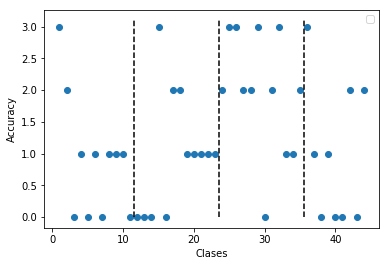

In [0]:
y = np.arange(1,45)
pred_PPM=[]
for i, values in enumerate(predictions_PPM):
  values = values[0]
  if(max(values) == values[0]):
    pred_PPM.append(0)
  elif(max(values) == values[1]):
    pred_PPM.append(1)
  elif(max(values) == values[2]):
    pred_PPM.append(2)
  elif(max(values) == values[3]):
    pred_PPM.append(3)
print(pred_PPM)

plt.scatter(y,pred_PPM)
plt.vlines(11.5,0,3.1, colors='k', linestyles='dashed')
plt.vlines(23.5,0,3.1, colors='k', linestyles='dashed')
plt.vlines(35.5,0,3.1, colors='k', linestyles='dashed')
plt.xlabel('Clases')
plt.ylabel('Accuracy')
plt.legend()

true_AN = [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3]


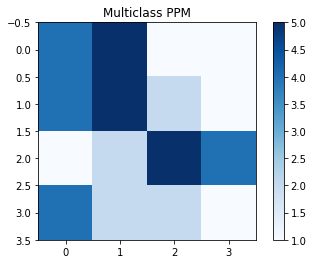

In [0]:
from sklearn.metrics import confusion_matrix
pred_PPM = [3, 2, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 3, 0, 2, 2, 1, 1, 1, 1, 1, 2, 3, 3, 2, 2, 3, 0, 2, 3, 1, 1, 2, 3, 1, 0, 1, 0, 0, 2, 0, 2]
true_PPM = [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3]

cm_PPM = confusion_matrix(true_PPM, pred_PPM)#, labels=["HF-I", "HF-NI", "HYP", "N"])
plt.imshow(cm_PPM, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Multiclass PPM")
plt.colorbar();

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

print("Accuracy: ", accuracy_score(true_PPM, pred_PPM))
print("F1-Score: ", f1_score(true_PPM, pred_PPM, average="weighted"))     

Accuracy:  0.3409090909090909
F1-Score:  0.33776356219538034


***Conv3D + Flujo óptico***

In [0]:
X_train_flow, paths_flow= creating_train(first, 'OF-PPM')
print(X_train_flow.shape)
paths_flow.shape

(44,)


(44,)

In [0]:
#classify(X_train_flow, paths_flow)
history_FLOW = classify(paths_flow)

(43,) (1,) Iteración:  1
Epoch 1/20


W0730 03:04:23.859591 139864481843072 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/clip_ops.py:157: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


10/10 [==============================] - 9s 923ms/step - loss: 5.5388 - acc: 0.2500 - val_loss: 3.7924 - val_acc: 1.0000
Epoch 2/20
10/10 [==============================] - 4s 438ms/step - loss: 4.4358 - acc: 0.3750 - val_loss: 5.2168 - val_acc: 0.0000e+00
Epoch 3/20
10/10 [==============================] - 7s 693ms/step - loss: 4.2446 - acc: 0.4250 - val_loss: 4.7154 - val_acc: 0.0000e+00
Epoch 4/20
10/10 [==============================] - 5s 533ms/step - loss: 4.1805 - acc: 0.4500 - val_loss: 4.8323 - val_acc: 0.0000e+00
Epoch 5/20
10/10 [==============================] - 5s 521ms/step - loss: 4.0714 - acc: 0.5750 - val_loss: 5.1405 - val_acc: 0.0000e+00
Epoch 6/20
10/10 [==============================] - 5s 482ms/step - loss: 3.8069 - acc: 0.6250 - val_loss: 5.2550 - val_acc: 0.0000e+00
Epoch 7/20
10/10 [==============================] - 6s 637ms/step - loss: 3.8157 - acc: 0.6250 - val_loss: 5.2194 - val_acc: 0.0000e+00
Epoch 8/20
10/10 [==============================] - 6s 603ms/st

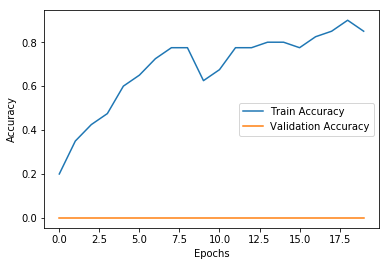

In [0]:
plt.plot(history_FLOW.history['acc'], label='Train Accuracy')
plt.plot(history_FLOW.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [0]:
history_FLOW, predictions_FLOW = classify(paths_flow)

Iteración:  1
Epoch 1/20


W0731 15:40:32.695242 140267211483008 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/clip_ops.py:157: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


10/10 [==============================] - 7s 720ms/step - loss: 5.9150 - acc: 0.1500
Epoch 2/20
10/10 [==============================] - 7s 720ms/step - loss: 5.9150 - acc: 0.1500
Epoch 2/20
10/10 [==============================] - 5s 501ms/step - loss: 4.7528 - acc: 0.2500
Epoch 3/20
10/10 [==============================] - 5s 508ms/step - loss: 4.4450 - acc: 0.3500
Epoch 4/20
10/10 [==============================] - 5s 495ms/step - loss: 4.1910 - acc: 0.3500
Epoch 5/20
10/10 [==============================] - 5s 522ms/step - loss: 4.1234 - acc: 0.4750
Epoch 6/20
10/10 [==============================] - 5s 500ms/step - loss: 4.1358 - acc: 0.4500
Epoch 7/20
10/10 [==============================] - 5s 530ms/step - loss: 3.8780 - acc: 0.5750
Epoch 8/20
10/10 [==============================] - 5s 493ms/step - loss: 3.9739 - acc: 0.4750
Epoch 9/20
10/10 [==============================] - 6s 552ms/step - loss: 3.8629 - acc: 0.6000
Epoch 10/20
10/10 [==============================] - 5s 500ms

In [0]:
y = np.arange(1,45)
pred_FLOW=[]
for i, values in enumerate(predictions_FLOW):
  values = values[0]
  if(max(values) == values[0]):
    pred_FLOW.append(0)
  elif(max(values) == values[1]):
    pred_FLOW.append(1)
  elif(max(values) == values[2]):
    pred_FLOW.append(2)
  elif(max(values) == values[3]):
    pred_FLOW.append(3)
print(pred_FLOW)

plt.scatter(y,pred_FLOW)
plt.vlines(11.5,0,3.1, colors='k', linestyles='dashed')
plt.vlines(23.5,0,3.1, colors='k', linestyles='dashed')
plt.vlines(35.5,0,3.1, colors='k', linestyles='dashed')
plt.xlabel('Clases')
plt.ylabel('Accuracy')
plt.legend()

true_FLOW = [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3]


In [0]:
from sklearn.metrics import confusion_matrix
#pred_FLOW = 
true_FLOW = [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3]

cm_FLOW = confusion_matrix(true_FLOW, pred_FLOW)#, labels=["HF-I", "HF-NI", "HYP", "N"])
plt.imshow(cm_FLOW, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Multiclass FLujo")
plt.colorbar();

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

print("Accuracy: ", accuracy_score(true_FLOW, pred_FLOW))
print("F1-Score: ", f1_score(true_FLOW, pred_FLOW, average="weighted"))     

***Conv3D + Aceleracion normal***

In [0]:
X_train_AN, paths_AN = creating_train(first, 'AN-PPM')
print(X_train_AN.shape)
paths_AN.shape

(44, 0)


(44,)

In [0]:
history_AN, predictions = classify(paths_AN)

(43,) (1,) Iteración:  1
Epoch 1/20


W0730 20:54:14.842275 139868626696064 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/clip_ops.py:157: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


10/10 [==============================] - 99s 10s/step - loss: 12.7656 - acc: 0.3000
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 6.4183 - acc: 0.1500
Epoch 3/20
10/10 [==============================] - 5s 522ms/step - loss: 4.8949 - acc: 0.3750
Epoch 4/20
10/10 [==============================] - 5s 472ms/step - loss: 4.4360 - acc: 0.3250
Epoch 5/20
10/10 [==============================] - 5s 484ms/step - loss: 4.3308 - acc: 0.3250
Epoch 6/20
10/10 [==============================] - 5s 500ms/step - loss: 4.0753 - acc: 0.5500
Epoch 7/20
10/10 [==============================] - 5s 533ms/step - loss: 3.9950 - acc: 0.5500
Epoch 8/20
10/10 [==============================] - 5s 475ms/step - loss: 3.9674 - acc: 0.5250
Epoch 9/20
10/10 [==============================] - 5s 512ms/step - loss: 3.8746 - acc: 0.6000
Epoch 10/20
10/10 [==============================] - 5s 484ms/step - loss: 3.7865 - acc: 0.6250
Epoch 11/20
10/10 [==============================] - 5s 510ms/

W0731 00:01:49.263120 139868626696064 legend.py:1289] No handles with labels found to put in legend.


[3, 3, 1, 2, 3, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 2, 2, 1, 1, 1, 0, 2, 2, 3, 3, 3, 2, 1, 0, 3, 3, 1, 2, 2, 2, 0, 2, 3, 1, 2, 2, 0]


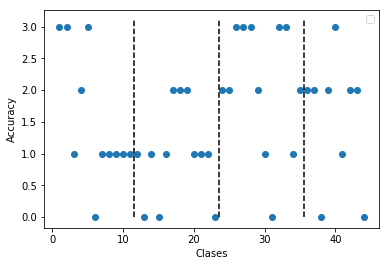

In [0]:
y = np.arange(1,45)
pred_AN=[]
for i, values in enumerate(predictions):
  values = values[0]
  if(max(values) == values[0]):
    pred_AN.append(0)
  elif(max(values) == values[1]):
    pred_AN.append(1)
  elif(max(values) == values[2]):
    pred_AN.append(2)
  elif(max(values) == values[3]):
    pred_AN.append(3)
print(pred_AN)

plt.scatter(y,pred_AN)
plt.vlines(11.5,0,3.1, colors='k', linestyles='dashed')
plt.vlines(23.5,0,3.1, colors='k', linestyles='dashed')
plt.vlines(35.5,0,3.1, colors='k', linestyles='dashed')
plt.xlabel('Clases')
plt.ylabel('Accuracy')
plt.legend()

true_AN = [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3]


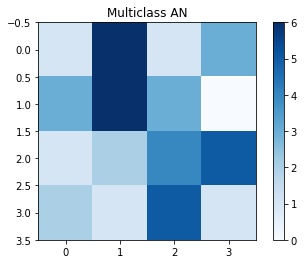

In [0]:
from sklearn.metrics import confusion_matrix
pred_AN = [3, 3, 1, 2, 3, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 2, 2, 1, 1, 1, 0, 2, 2, 3, 3, 3, 2, 1, 0, 3, 3, 1, 2, 2, 2, 0, 2, 3, 1, 2, 2, 0]
true_AN = [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3]

cm_AN = confusion_matrix(true_AN, pred_AN)#, labels=["HF-I", "HF-NI", "HYP", "N"])
plt.imshow(cm_AN, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Multiclass AN")
plt.colorbar();

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

print("Accuracy: ", accuracy_score(true_AN, pred_AN))
print("F1-Score: ", f1_score(true_AN, pred_AN, average="weighted"))     

Accuracy:  0.2727272727272727
F1-Score:  0.25898989898989905


In [0]:
pred_AN = [3,3,1,2,3,0,1,1,1,1,1,1,0,1,0,1,2,2,2,1,1,1,0,2,2,3,3,3,2,1,0,3,3,1,2,2,2,0,2,3,1,2,2,0]
true_AN = [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3]

P_1 = [3,3,1,2,3,0,1,1,1,1,1,1,0,1,0,1,2,2,2,1,1,1,0]
T_1 = [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1]
print("Accuracy: ", accuracy_score(P_1, T_1))
print("F1-Score: ", f1_score(P_1, T_1, average="weighted"))     

P_2 = [3,3,1,2,3,0,1,1,1,1,1,2,2,3,3,3,2,1,0,3,3,1,2]
T_2 = [0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2]
print("Accuracy: ", accuracy_score(P_2, T_2))
print("F1-Score: ", f1_score(P_2, T_2, average="weighted"))  

P_3 = [3,3,1,2,3,0,1,1,1,1,1,2,2,0,2,3,1,2,2,0]
T_3 = [0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3]
print("Accuracy: ", accuracy_score(P_3, T_3))
print("F1-Score: ", f1_score(P_3, T_3, average="weighted"))  

P_4 = [1,0,1,0,1,2,2,2,1,1,1,0,2,2,3,3,3,2,1,0,3,3,1,2]
T_4 = [1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2]
print("Accuracy: ", accuracy_score(P_4, T_4))
print("F1-Score: ", f1_score(P_4, T_4, average="weighted"))  

P_5 = [1,0,1,0,1,2,2,2,1,1,1,0,2,2,0,2,3,1,2,2,0]
T_5 = [1,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3]
print("Accuracy: ", accuracy_score(P_5, T_5))
print("F1-Score: ", f1_score(P_5, T_5, average="weighted"))  

P_6 = [2,2,3,3,3,2,1,0,3,3,1,2,2,2,0,2,3,1,2,2,0]
T_6 = [2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3]
print("Accuracy: ", accuracy_score(P_6, T_6))
print("F1-Score: ", f1_score(P_6, T_6, average="weighted"))  

:***Conv3D + Aceleración tangencial***

In [0]:
X_train_AT, paths_AT = creating_train(first, 'AT-PPM')
print(X_train_AT.shape)
paths_AT.shape

(44, 0)


(44,)

In [0]:
history_AT, predictions_AT = classify(paths_AT)

Iteración:  1
Epoch 1/20


W0731 04:09:10.492095 139634814064512 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/clip_ops.py:157: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


10/10 [==============================] - 7s 747ms/step - loss: 17.7770 - acc: 0.3000
Epoch 2/20
10/10 [==============================] - 5s 538ms/step - loss: 13.9452 - acc: 0.2500
Epoch 3/20
10/10 [==============================] - 6s 557ms/step - loss: 8.6450 - acc: 0.2250
Epoch 4/20
10/10 [==============================] - 5s 532ms/step - loss: 5.8630 - acc: 0.2250
Epoch 5/20
10/10 [==============================] - 6s 551ms/step - loss: 4.8846 - acc: 0.2250
Epoch 6/20
10/10 [==============================] - 5s 528ms/step - loss: 4.9569 - acc: 0.2750
Epoch 7/20
10/10 [==============================] - 5s 538ms/step - loss: 4.6814 - acc: 0.2750
Epoch 8/20
10/10 [==============================] - 5s 522ms/step - loss: 4.3014 - acc: 0.2750
Epoch 9/20
10/10 [==============================] - 6s 569ms/step - loss: 4.2379 - acc: 0.4000
Epoch 10/20
10/10 [==============================] - 5s 520ms/step - loss: 4.1616 - acc: 0.4500
Epoch 11/20
10/10 [==============================] - 6s 56

W0731 05:51:52.568842 139634814064512 legend.py:1289] No handles with labels found to put in legend.


[1, 1, 2, 2, 1, 0, 2, 1, 1, 3, 2, 1, 0, 0, 0, 1, 2, 3, 1, 0, 1, 1, 1, 2, 2, 1, 3, 0, 3, 3, 2, 3, 2, 3, 2, 2, 2, 1, 2, 0, 3, 0, 3, 2]


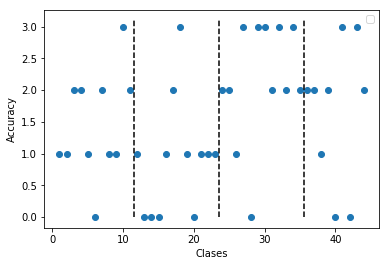

In [0]:
y = np.arange(1,45)
pred_AT=[]
for i, values in enumerate(predictions_AT):
  values = values[0]
  if(max(values) == values[0]):
    pred_AT.append(0)
  elif(max(values) == values[1]):
    pred_AT.append(1)
  elif(max(values) == values[2]):
    pred_AT.append(2)
  elif(max(values) == values[3]):
    pred_AT.append(3)
print(pred_AT)

plt.scatter(y,pred_AT)
plt.vlines(11.5,0,3.1, colors='k', linestyles='dashed')
plt.vlines(23.5,0,3.1, colors='k', linestyles='dashed')
plt.vlines(35.5,0,3.1, colors='k', linestyles='dashed')
plt.xlabel('Clases')
plt.ylabel('Accuracy')
plt.legend()

true_AT = [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3]


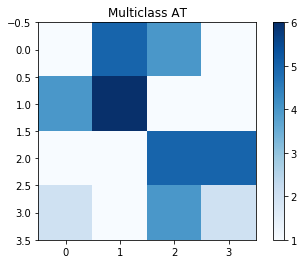

In [0]:
pred_AT = [1, 1, 2, 2, 1, 0, 2, 1, 1, 3, 2, 1, 0, 0, 0, 1, 2, 3, 1, 0, 1, 1, 1, 2, 2, 1, 3, 0, 3, 3, 2, 3, 2, 3, 2, 2, 2, 1, 2, 0, 3, 0, 3, 2]
true_AT = [0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3]


cm_AT = confusion_matrix(true_AT, pred_AT)#, labels=["0", "1", "2", "3"])
plt.imshow(cm_AT, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Multiclass AT")
plt.colorbar();

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

print("Accuracy: ", accuracy_score(true_AT, pred_AT))
print("F1-Score: ", f1_score(true_AT, pred_AT, average="weighted"))     

Accuracy:  0.3181818181818182
F1-Score:  0.30757453073242547


***Prueba***

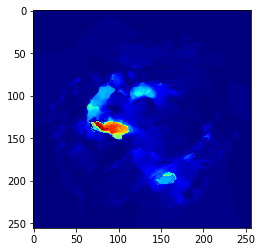

In [0]:
 a = '/content/gdrive/My Drive/Tesis/OF-PPM/0-HF-I-02/3/000013.ppm'
b = '/content/gdrive/My Drive/Tesis/OF-PPM/0-HF-I-02/3/000014.ppm'
a = plt.imread(a)
b = plt.imread(b)

img_a = cv2.cvtColor(a, cv2.COLOR_BGR2YCrCb)
img_b = cv2.cvtColor(b, cv2.COLOR_BGR2YCrCb)

imgsc_a = scale_ycrcb(img_a)[:,:,1:]
imgsc_b = scale_ycrcb(img_b)[:,:,1:]
mag_a, ang_a = arrowsimg(imgsc_a, 90)
mag_b, ang_b = arrowsimg(imgsc_b, 90)


vty_a, vtx_a = vel_tang(mag_a,imgsc_a[:,:,0], imgsc_a[:,:,1]) #VT_A        
vty_b, vtx_b = vel_tang(mag_b,imgsc_b[:,:,0], imgsc_b[:,:,1]) #VT_B
mag_vt = np.sqrt((vtx_a)**2 + (vty_a)**2)
vny, vnx, mag_vn = vel_normal(vty_a, vtx_a,mag_a,vty_b,vtx_b) #VN
mag_dev = acl_tan(mag_a,mag_b) #AT
an_ = acl_normal(mag_a,mag_vn) #AN
an_img = np.array(an_, dtype = np.uint8)
cinematic = cv2.applyColorMap(an_img, cv2.COLORMAP_JET)
#print(an_-cinematic)
plt.imshow(an_, cmap='jet')
#cv2.imwrite('/content/gdrive/My Drive/Tesis/DATASET/AN-PPM/prueba_1.jpg', cinematic)